## Step 1

In [41]:
import cv2
import pywt

# size H x L (256 x 256)
D = cv2.imread('peppers.bmp', cv2.IMREAD_GRAYSCALE)
F = cv2.imread('baboon.bmp', cv2.IMREAD_GRAYSCALE)

# three-layer discrete wavelet transform
J = pywt.wavedec2(D, 'haar', level = 3)
I = pywt.wavedec2(F, 'haar', level = 3)

## Step 2

In [42]:
import numpy as np
import math
from matplotlib import pyplot as plt

# coefficient matrices
cA3, (cH3, cV3, cD3), (cH2, cV2, cD2), (cH1, cV1, cD1) = J

AH3 = np.concatenate([cA3, cH3], axis=1)
VD3 = np.concatenate([cV3, cD3], axis=1)
cA2 = np.concatenate([AH3, VD3], axis=0)

AH2 = np.concatenate([cA2, cH2], axis=1)
VD2 = np.concatenate([cV2, cD2], axis=1)
cA1 = np.concatenate([AH2, VD2], axis=0)

AH = np.concatenate([cA1, cH1], axis=1)
VD = np.concatenate([cV1, cD1], axis=1)
J_concat = np.concatenate([AH, VD], axis=0)

# absolute values for all elements of J
N = abs(J_concat)

# elements of N are sorted in descending order
N_flatten = N.flatten()
O = sorted(N_flatten, reverse = True)

# threshold
index = math.floor(len(O) * 0.15)
threshold = O[index]

# set the elements in J less than threshold by the absolute operation to be zeros
Q = J_concat.copy()

for i in range(Q.shape[0]):
    for j in range(Q.shape[1]):
        if abs(Q[i][j]) < threshold:
            Q[i][j] = 0

# plt.imshow(J_concat, cmap = 'gray')
# plt.axis('off')
# plt.show()

## Step 3

In [43]:
# coefficient matrices
cA3, (cH3, cV3, cD3), (cH2, cV2, cD2), (cH1, cV1, cD1) = I

AH3 = np.concatenate([cA3, cH3], axis=1)
VD3 = np.concatenate([cV3, cD3], axis=1)
cA2 = np.concatenate([AH3, VD3], axis=0)

AH2 = np.concatenate([cA2, cH2], axis=1)
VD2 = np.concatenate([cV2, cD2], axis=1)
cA1 = np.concatenate([AH2, VD2], axis=0)

AH = np.concatenate([cA1, cH1], axis=1)
VD = np.concatenate([cV1, cD1], axis=1)
I_concat = np.concatenate([AH, VD], axis=0)

# absolute values for all elements of I
N = abs(I_concat)

# elements of N are sorted in descending order
N_flatten = N.flatten()
O = sorted(N_flatten, reverse = True)

# threshold
index = math.floor(len(O) * 0.15)
threshold = O[index]

# set the elements in I less than threshold by the absolute operation to be zeros
R = I_concat.copy()

for i in range(R.shape[0]):
    for j in range(R.shape[1]):
        if abs(R[i][j]) < threshold:
            R[i][j] = 0

# plt.imshow(I_concat, cmap = 'gray')
# plt.axis('off')
# plt.show()

## Step 4

In [44]:
from PIL import Image
from scipy.stats import entropy

# calculate the entropy of the image
def image_entropy(img):
    histogram, _ = np.histogram(img.flatten(), bins=256, range=(0, 256), density=True)

    entropy_value = entropy(histogram)

    return entropy_value

entropy_D = image_entropy(D)
entropy_F = image_entropy(F)

# the three initial values of the ImproBsys chaotic system
x0 = ((entropy_D * (10 ** 10)) % 1 + 0.36255) % 1
y0 = ((entropy_F * (10 ** 10)) % 1 + 0.45368) % 1
z0 = (x0 + y0 + 0.24142) % 1

# sign function in the ImproBsys chaotic system
def sign(x):
    if x > 0:
        return 1
    elif x == 0:
        return 0
    else:
        return -1

# f function in the ImproBsys chaotic system
def f_function(x):
    A = 2
    B = 0.25

    output = B * sign(x) + B * sign(x-2*A) + B * sign(x+2*A)

    return output

# ImproBsys chaotic system function
def ImproBsys_chaotic_system(length, x0, y0, z0):
    x = x0
    y = y0
    z = z0
    system = [x, y, z]

    a = 1.0
    b = 1.0
    c = 1.0
    d = 2.0
    e = 1.0

    for i in range(length - 3):
        x_dot = a * y * z
        y_dot = b * x - c * y
        z_dot = d - e * x * y - f_function(x * y)

        x += x_dot * 0.01
        y += y_dot * 0.01
        z += z_dot * 0.01

        system.append(x)

    return system

length_H = D.shape[0]
# get the chaotic sequence S of length H
S = ImproBsys_chaotic_system(length_H, x0, y0, z0)

# get the sorted index sequence of the chaotic sequence S
T = np.argsort(S)

# the function that create the Hadamard matrix
def hadamard_matrix(n):
    if n == 1:
        return np.array([[1]])

    H = hadamard_matrix(n//2)
    upper_left = np.hstack((H, H))
    lower_left = np.hstack((H, -H))
    hadamard = np.vstack((upper_left, lower_left))

    return hadamard

# generate the Hadamard matrix
U = hadamard_matrix(length_H*2)

# select round(H/2) row from U according to the index sequence T
V = np.zeros((length_H, length_H),dtype=float)
for i in range(length_H):
    for j in range(length_H):
        V[i, j] = U[T[i], T[j]]

inv = np.linalg.inv(V)
# print(inv)
K = inv@V
# print(K)

## Step 5

In [45]:
W = np.dot(V,Q)
X = np.dot(V,R)
Y = np.concatenate((W, X), axis=0)
# print(Y)

## Step 6

In [46]:
# Normalize the matrix Y
# Because the difference of the maximum and the minimum of the matrix Y is too big, 
# if we want to reduce the matrix Y from the normalized matrix Z then it will cause big error,
# so we store the quotient after doing the modulo to make sure we can reduce the matrix Y from Z with no error.
minY = np.min(Y)
Z = Y.copy()
Z = Z.astype(int)
minZ = np.min(Z)
for i in range(Z.shape[0]):
    for j in range(Z.shape[1]):
        Z[i,j] = Z[i,j]-minZ

Key = np.zeros_like(Z)
img = np.zeros_like(Z)
for i in range(Z.shape[0]):
    for j in range(Z.shape[1]):
        Key[i,j] = Z[i,j]//255
        img[i,j] = Z[i,j]%255

# print(Key)
# print(img)

cv2.imwrite("Z.png",img)
# cv2.imshow("Z", Z)
# cv2.waitKey(0)
# cv2.destroyAllWindows()


True

## Step 7

In [47]:
import cv2
import numpy as np
from cryptography.hazmat.primitives.asymmetric import ec
from cryptography.hazmat.primitives import serialization
from cryptography.hazmat.primitives import hashes
from cryptography.hazmat.primitives.kdf.hkdf import HKDF
from cryptography.hazmat.primitives.ciphers import Cipher, algorithms, modes

# ECC key pair is used to encrypt the AES shared key to make sure the key exchange protocol is secure.
def generate_ecc_key_pair():
    private_key = ec.generate_private_key(ec.SECP256R1())
    public_key = private_key.public_key()
    return private_key, public_key

# Shared key is used to encrypt the image by AES algorithm
def generate_shared_key(private_key, public_key):
    shared_key = private_key.exchange(ec.ECDH(), public_key)
    derived_key = HKDF(
        algorithm=hashes.SHA256(),
        length=32,
        salt=None,
        info=b'',
    ).derive(shared_key)
    return derived_key

def encrypt_image(image_path, shared_key):
    # Read image
    image = cv2.imread(image_path)

    # Convert image to byte array
    image_bytes = image.tobytes()

    # Generate random IV
    iv = np.random.bytes(16)

    # Encrypt image using AES with shared key
    cipher = Cipher(algorithms.AES(shared_key), modes.CBC(iv))
    encryptor = cipher.encryptor()
    encrypted_image = encryptor.update(image_bytes) + encryptor.finalize()

    # Convert encrypted image byte array to image
    encrypted_image_arr = np.frombuffer(encrypted_image, dtype=np.uint8)
    encrypted_image_arr = encrypted_image_arr.reshape(image.shape)


    cv2.imwrite('encrypted_image.png', encrypted_image_arr)
    # Display encrypted image
    # cv2.imshow("Encrypted Image", encrypted_image_arr)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()

    return encrypted_image, iv

# Main program
if __name__ == "__main__":
    # Set image path
    image_path = "Z.png"

    # Generate ECC key pair
    private_key, public_key = generate_ecc_key_pair()

    # Serialize public key
    public_key_bytes = public_key.public_bytes(
        encoding=serialization.Encoding.PEM,
        format=serialization.PublicFormat.SubjectPublicKeyInfo
    )

    # Save public key to file
    with open("public_key.pem", "wb") as file:
        file.write(public_key_bytes)

    # Save private key to file
    private_key_pem = private_key.private_bytes(
        encoding=serialization.Encoding.PEM,
        format=serialization.PrivateFormat.PKCS8,
        encryption_algorithm=serialization.NoEncryption()
    )

    with open("private_key.pem", "wb") as private_key_file:
        private_key_file.write(private_key_pem)

    # Generate shared key
    shared_key = generate_shared_key(private_key, public_key)

    # Encrypt image
    encrypted_image, iv = encrypt_image(image_path, shared_key)

    # Save encrypted image and IV to file
    with open("encrypted_image.dat", "wb") as file:
        file.write(encrypted_image)
    with open("iv.dat", "wb") as file:
        file.write(iv)

## Decryption

In [48]:
import cv2
import numpy as np
from cryptography.hazmat.primitives.asymmetric import ec
from cryptography.hazmat.primitives import serialization
from cryptography.hazmat.primitives import hashes
from cryptography.hazmat.primitives.kdf.hkdf import HKDF
from cryptography.hazmat.primitives.ciphers import Cipher, algorithms, modes

def load_private_key(private_key_path):
    with open(private_key_path, "rb") as file:
        private_key_bytes = file.read()
    private_key = serialization.load_pem_private_key(
        private_key_bytes,
        password=None
    )
    return private_key

def generate_shared_key(private_key, public_key):
    shared_key = private_key.exchange(ec.ECDH(), public_key)
    derived_key = HKDF(
        algorithm=hashes.SHA256(),
        length=32,
        salt=None,
        info=b'',
    ).derive(shared_key)
    return derived_key

def decrypt_image(encrypted_image_path, iv_path, shared_key):
    # Read encrypted image and IV from files
    with open(encrypted_image_path, "rb") as file:
        encrypted_image = file.read()
    with open(iv_path, "rb") as file:
        iv = file.read()
    
    img = cv2.imread("encrypted_image.png")
    height, width, channels = img.shape

    # Decrypt image using AES with shared key and IV
    cipher = Cipher(algorithms.AES(shared_key), modes.CBC(iv))
    decryptor = cipher.decryptor()
    decrypted_image_bytes = decryptor.update(encrypted_image) + decryptor.finalize()

    # Convert byte array to image
    decrypted_image_arr = np.frombuffer(decrypted_image_bytes, dtype=np.uint8)
    decrypted_image_arr = decrypted_image_arr.reshape((height, width, channels))

    return decrypted_image_arr

# Main program
if __name__ == "__main__":
    # Set encrypted image and IV paths
    encrypted_image_path = "encrypted_image.dat"
    iv_path = "iv.dat"

    # Load private key from file
    private_key_path = "private_key.pem"
    private_key = load_private_key(private_key_path)

    # Generate ECC public key from private key
    public_key = private_key.public_key()

    # Generate shared key
    shared_key = generate_shared_key(private_key, public_key)

    # Decrypt image
    decrypted_image = decrypt_image(encrypted_image_path, iv_path, shared_key)

    cv2.imwrite('decrypted_image.png', decrypted_image)

    # Display decrypted image
    # cv2.imshow("Decrypted Image", decrypted_image)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()

In [49]:
# Reduce the decrypted matrix to the matrix Y
# Because of the encrypt and decrypt algorithm, it will cause a little error
# To make sure we can reduce the image currectly we have the matrix 'key' with the quotient after modulo, the multiple operator V. 

r_img = cv2.imread('decrypted_image.png',cv2.IMREAD_GRAYSCALE)
restored = np.zeros_like(Z)
for i in range(restored.shape[0]):
    for j in range(restored.shape[1]):
        restored[i,j] = Key[i,j]*255+r_img[i,j]+minY

r_W = restored[:length_H,:]
r_X = restored[length_H:,:]
r_Q = inv@r_W
r_R = inv@r_X



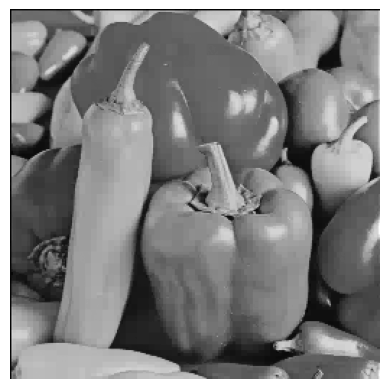

In [50]:
# The inverse of the three-layer discrete wavelet transform
import numpy as np
import pywt
from matplotlib import pyplot as plt


AH_de, VD_de = np.split(r_Q, 2, axis = 0)
cV1_de, cD1_de = np.split(VD_de, 2, axis = 1)
cA1_de, cH1_de = np.split(AH_de, 2, axis = 1)

AH2_de, VD2_de = np.split(cA1_de, 2, axis = 0)
cV2_de, cD2_de = np.split(VD2_de, 2, axis = 1)
cA2_de, cH2_de = np.split(AH2_de, 2, axis = 1)

AH3_de, VD3_de = np.split(cA2_de, 2, axis = 0)
cV3_de, cD3_de = np.split(VD3_de, 2, axis = 1)
cA3_de, cH3_de = np.split(AH3_de, 2, axis = 1)

J_de = cA3_de, (cH3_de, cV3_de, cD3_de), (cH2_de, cV2_de, cD2_de), (cH1_de, cV1_de, cD1_de)

D_de = pywt.waverec2(J_de, 'haar')
cv2.imwrite('D_de.png', D_de)

plt.imshow(D_de, cmap = 'gray')
plt.axis('off')
plt.show()

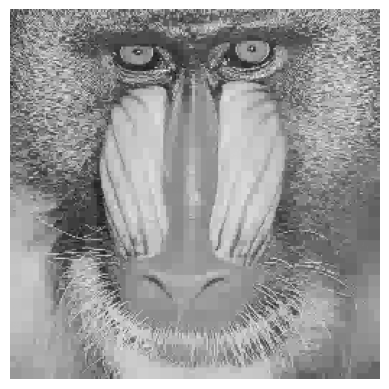

In [51]:
AH_de, VD_de = np.split(r_R, 2, axis = 0)
cV1_de, cD1_de = np.split(VD_de, 2, axis = 1)
cA1_de, cH1_de = np.split(AH_de, 2, axis = 1)

AH2_de, VD2_de = np.split(cA1_de, 2, axis = 0)
cV2_de, cD2_de = np.split(VD2_de, 2, axis = 1)
cA2_de, cH2_de = np.split(AH2_de, 2, axis = 1)

AH3_de, VD3_de = np.split(cA2_de, 2, axis = 0)
cV3_de, cD3_de = np.split(VD3_de, 2, axis = 1)
cA3_de, cH3_de = np.split(AH3_de, 2, axis = 1)

I_de = cA3_de, (cH3_de, cV3_de, cD3_de), (cH2_de, cV2_de, cD2_de), (cH1_de, cV1_de, cD1_de)

F_de = pywt.waverec2(I_de, 'haar')
cv2.imwrite('F_de.png', F_de)

plt.imshow(F_de, cmap = 'gray')
plt.axis('off')
plt.show()

## PSNR

In [6]:
import cv2
peppers_before = cv2.imread('peppers.bmp', cv2.IMREAD_GRAYSCALE)
peppers_de = cv2.imread('D_de.png', cv2.IMREAD_GRAYSCALE)
baboon_before = cv2.imread('baboon.bmp', cv2.IMREAD_GRAYSCALE)
baboon_de = cv2.imread('F_de.png', cv2.IMREAD_GRAYSCALE)

h, w = peppers_before.shape
en_img = cv2.imread('encrypted_image.png', cv2.IMREAD_GRAYSCALE)

peppers_en = en_img[:h][:]
baboon_en = en_img[h:][:]
# cv2.imshow("peppers_en", peppers_en)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

print('Original peppers image and encrypted peppers image')
print(cv2.PSNR(peppers_before, peppers_en))

print('Original peppers image and decrypted peppers image')
print(cv2.PSNR(peppers_before, peppers_de))

print('Original baboon image and encrypted baboon image')
print(cv2.PSNR(baboon_before, baboon_en))

print('Original baboon image and decrypted baboon image')
print(cv2.PSNR(baboon_before, baboon_de))


Original peppers image and encrypted peppers image
11.069938688820962
Original peppers image and decrypted peppers image
34.89619527065627
Original baboon image and encrypted baboon image
11.908562364863965
Original baboon image and decrypted baboon image
25.05556935188633
